In [43]:
import torch
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import uuid
import sys

In [44]:
sys.path.append("../")
import TorchData

In [45]:
import importlib
importlib.reload(TorchData.metric)

<module 'TorchData.metric' from '/Users/CATFOOL/Projects/ResearchProject/TorchData/metric.py'>

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [94]:
X=88
Y=128
T_OFFSET=100
NUM_DATA=5096
SIGNAL_COUNT_MIN=25
SIGNAL_COUNT_MAX=26
SIGNAL_SELECT_MODE="retain"
NOISE_DENSITY=0.01
NOISE_MAGNITUDE=1.0
BLUR_LEVEL=0
DISPERSION_LEVEL=0
MODE="normal"

BATCH_SIZE=512
EPOCH=100
MULTI_GPU=True

model_name = "HybridTransformer"


In [95]:
# set random seed for reproducibility
import numpy as np
np.random.seed(0)

In [48]:
train_dataset = TorchData.TORCHData(x=X, y=Y, num_data=NUM_DATA,
                                    signal_count=(SIGNAL_COUNT_MIN, SIGNAL_COUNT_MAX), signal_select_mode=SIGNAL_SELECT_MODE,
                                    noise_density=NOISE_DENSITY, t_offset=T_OFFSET,
                                    blur_level=BLUR_LEVEL, dispersion_level=DISPERSION_LEVEL, mode=MODE)
train_dataloader = train_dataset.dataloader(batch_size=BATCH_SIZE, shuffle=True)

In [96]:
test_dataset = TorchData.TORCHData(x=X, y=Y, num_data=1024,
                                   signal_count=(SIGNAL_COUNT_MIN, SIGNAL_COUNT_MAX), signal_select_mode=SIGNAL_SELECT_MODE,
                                   noise_density=NOISE_DENSITY, t_offset=T_OFFSET,
                                   blur_level=BLUR_LEVEL, dispersion_level=DISPERSION_LEVEL, mode=MODE)
test_dataloader = test_dataset.dataloader(batch_size=1, shuffle=False)

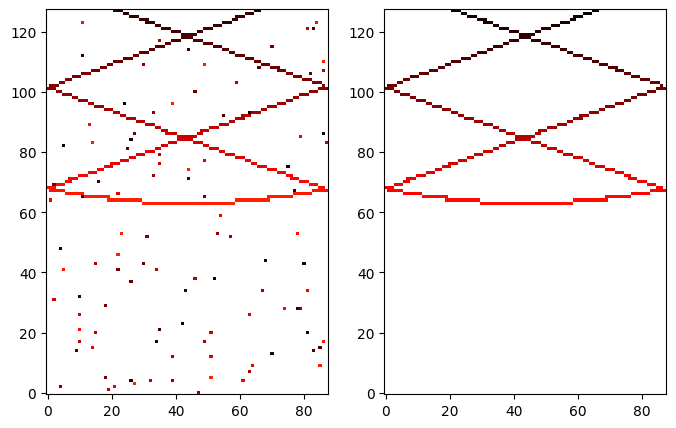

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(test_dataset.sn_time[0], aspect="auto", cmap="hot_r", origin="lower")
ax[1].imshow(test_dataset.signal_time[0], aspect="auto", cmap="hot_r", origin="lower")

In [56]:
class LearnablePositionalEncoding(torch.nn.Module):
    def __init__(self, embed_dim=64, max_seq_length=X*Y*4/64):
        super().__init__()
        self.pos_embed = torch.nn.Parameter(
            torch.zeros(1, int(max_seq_length), embed_dim),
            requires_grad=True
        )
        torch.nn.init.normal_(self.pos_embed, std=0.02)  # Xavier-style initialization

    def forward(self, x):
        B, seq, embed_size = x.shape
        return x + self.pos_embed[:, :seq]

In [57]:
class HybridTransformer(torch.nn.Module):
            def __init__(self, embed_dim=64, num_heads=4, num_layers=4):
                super().__init__()

                # CNN Encoder
                self.encoder = torch.nn.Sequential(
                    torch.nn.Conv2d(1, 32, 3, padding=1),
                    torch.nn.BatchNorm2d(32),
                    torch.nn.GELU(),
                    torch.nn.MaxPool2d(2),
                    torch.nn.Conv2d(32, 64, 3, padding=1),
                    torch.nn.BatchNorm2d(64),
                    torch.nn.GELU(),
                    torch.nn.MaxPool2d(2)
                )

                # Transformer
                self.transformer = torch.nn.TransformerEncoder(
                    torch.nn.TransformerEncoderLayer(
                        d_model=embed_dim,
                        nhead=num_heads,
                        dim_feedforward=4 * embed_dim,
                        batch_first=True,
                        norm_first=True,  # Better stability
                        activation="gelu",
                        dropout=0.1
                    ),
                    num_layers=num_layers
                )

                # CNN Decoder
                self.decoder = torch.nn.Sequential(
                    torch.nn.ConvTranspose2d(64, 64, 3, padding=1),
                    torch.nn.BatchNorm2d(64),
                    torch.nn.GELU(),
                    torch.nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
                    torch.nn.BatchNorm2d(32),
                    torch.nn.GELU(),
                    torch.nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
                )

                # self.pos_embed = torch.nn.Parameter(torch.randn(1, 690, embed_dim))
                self.learnable_position_embed = LearnablePositionalEncoding(embed_dim)
                # self.fixed_pos_embed = PositionalEncoding(embed_dim)

            def forward(self, x):
                # Encoder
                cnn_features = self.encoder(x)  # [B, 64, H/4, W/4]

                # Transformer processing
                B, C, H, W = cnn_features.shape
                x = cnn_features.flatten(2).permute(0, 2, 1)

                # x = x + self.pos_embed[:, :H*W, :]
                # x = self.fixed_pos_embed(x)
                x = self.learnable_position_embed(x)
                x = self.transformer(x)

                # Feature fusion
                x = x.permute(0, 2, 1).view(B, C, H, W)
                x = x + cnn_features  # Residual connection

                # Decoder pathway
                return self.decoder(x)


In [58]:
model = HybridTransformer()
if MULTI_GPU:
    model = torch.nn.DataParallel(model)
model = model.to(device)
#loss_function = torch.nn.MSELoss()
loss_function = TorchData.WeightedMSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
summary(model, input_size=(16, 1, Y, X))

Layer (type:depth-idx)                             Output Shape              Param #
DataParallel                                       [16, 1, 128, 88]          --
├─HybridTransformer: 1-1                           [16, 1, 128, 88]          --
│    └─Sequential: 2-1                             [16, 64, 32, 22]          --
│    │    └─Conv2d: 3-1                            [16, 32, 128, 88]         320
│    │    └─BatchNorm2d: 3-2                       [16, 32, 128, 88]         64
│    │    └─GELU: 3-3                              [16, 32, 128, 88]         --
│    │    └─MaxPool2d: 3-4                         [16, 32, 64, 44]          --
│    │    └─Conv2d: 3-5                            [16, 64, 64, 44]          18,496
│    │    └─BatchNorm2d: 3-6                       [16, 64, 64, 44]          128
│    │    └─GELU: 3-7                              [16, 64, 64, 44]          --
│    │    └─MaxPool2d: 3-8                         [16, 64, 32, 22]          --
│    └─LearnablePositionalEnc

In [12]:
scalar = torch.amp.GradScaler()

for epoch in tqdm(range(EPOCH)):
    for x, y in train_dataloader:
        optimiser.zero_grad()

        with torch.amp.autocast(device):
            outputs = model(x.to(device))
            loss = loss_function(outputs, y.to(device))

        scalar.scale(loss).backward()
        scalar.step(optimiser)
        scalar.update()

100%|██████████| 10/10 [00:54<00:00,  5.45s/it]


In [13]:
# uid = uuid.uuid4()
# file_name = f"{model_name}_{uid}.pth"
# torch.save(model.state_dict(), f"{file_name}")

In [97]:
### Using pretrained weights
model.load_state_dict(torch.load(f"../ModelWeights/HDT_vs_CAE/HybridTransformer_25.pth", map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [98]:
model.eval()
with torch.no_grad():
    pred = model(test_dataset.input_data.to(device)).to("cpu")

pred = test_dataset.input_data * (pred > 1)
test_dataset.predict_data = pred

(<Figure size 1401x400 with 4 Axes>,
 array([[<Axes: title={'center': 'Input Data'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 'Target Data'}, xlabel='X', ylabel='Y'>,
         <Axes: title={'center': 'Predict Data'}, xlabel='X', ylabel='Y'>]],
       dtype=object))

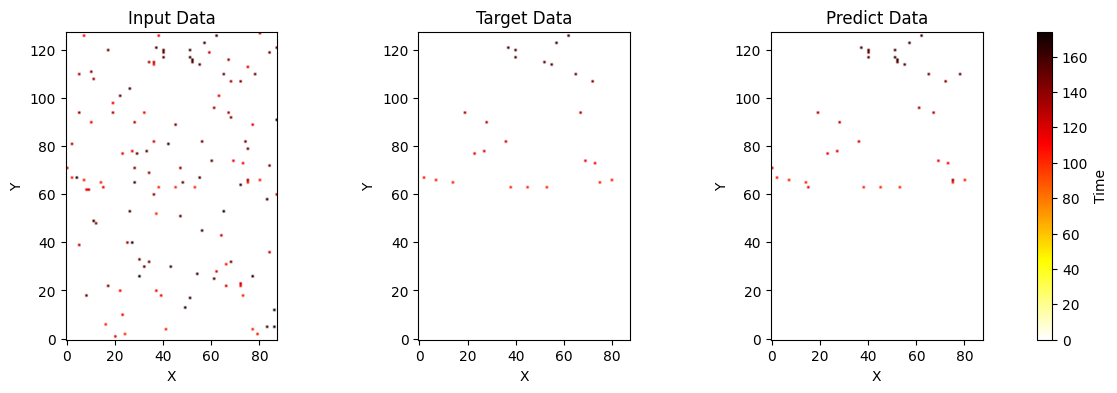

In [99]:
TorchData.plot2d_f(test_dataset, ["input_data", "target_data", "predict_data"], index=0, cmap="hot_r")

(<Figure size 1500x600 with 4 Axes>,
 array([[<Axes3D: title={'center': 'Input Data'}, xlabel='X', ylabel='Y', zlabel='Time'>,
         <Axes3D: title={'center': 'Target Data'}, xlabel='X', ylabel='Y', zlabel='Time'>,
         <Axes3D: title={'center': 'Predict Data'}, xlabel='X', ylabel='Y', zlabel='Time'>]],
       dtype=object))

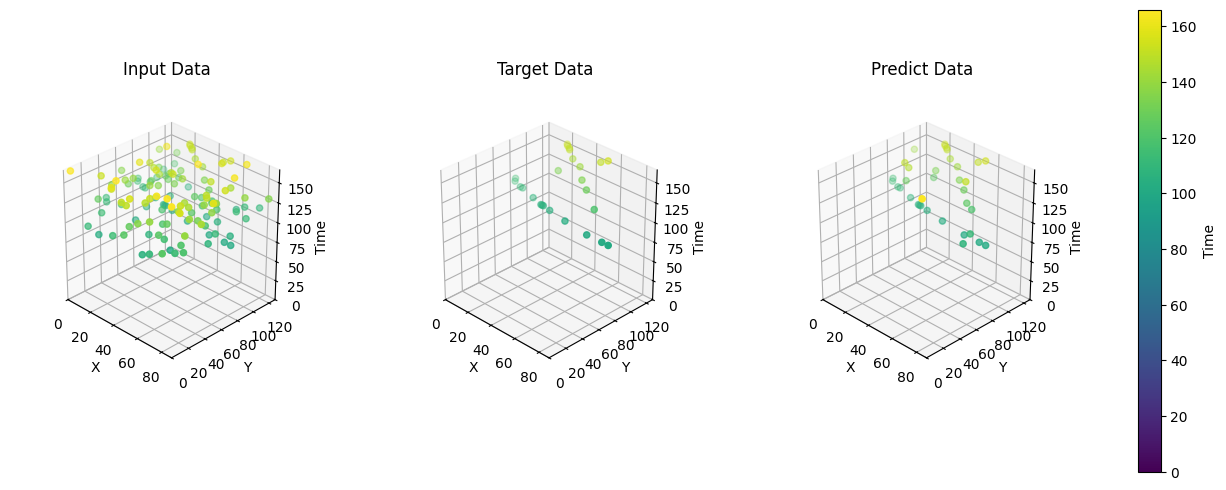

In [69]:
TorchData.visual.plot3d_f(test_dataset, ["input_data", "target_data", "predict_data"], index=0)

In [70]:
TorchData.get_metrics(test_dataset.target_data, test_dataset.predict_data, test_dataset.input_data)

torch.Size([1024, 1, 128, 88])


{'Signal Retention Rate': 0.9938671875,
 'Signal Retention Standard Deviation:': 0.017718670889735222,
 'Noise Removal Rate': 0.8879462155714596,
 'Noise Removal Standard Deviation:': 0.03684164583683014,
 'MSE': 24.591907501220703,
 'PSNR': 33.25077438354492,
 'SSIM': tensor(0.9579),
 'ROC AUC': 0.996289421513959,
 'F1': 0.7955909943714822,
 'F1 Standard Deviation:': 0.052950214594602585}